In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

# =========================================================
# 1. SETUP PATHS — AUTOMATICALLY FINDS THE TRAIN FOLDERS
# =========================================================

BASE = "/kaggle/input"

# find the dataset folder automatically
for root, dirs, files in os.walk(BASE):
    if "x-view2" in root.lower():
        DATASET_ROOT = root
        break

print("Dataset Root:", DATASET_ROOT)

TRAIN_ROOT = os.path.join(DATASET_ROOT, "X_view2/train/train")
IMG_DIR    = os.path.join(TRAIN_ROOT, "images")
LABEL_DIR  = os.path.join(TRAIN_ROOT, "labels")
TARGET_DIR = os.path.join(TRAIN_ROOT, "targets")

print("Images:", IMG_DIR)
print("Targets:", TARGET_DIR)

IMG_SIZE = 256

# =========================================================
# 2. LOAD DATASET (PRE + POST DISASTER)
# =========================================================

def group_ids(folder):
    """
    Example filenames:
      wildfire_000001_pre_disaster.png
      wildfire_000001_post_disaster.png
    We extract unique IDs: wildfire_000001
    """
    ids = set()
    for f in os.listdir(folder):
        if "_pre_disaster" in f:
            ids.add(f.replace("_pre_disaster.png",""))
    return sorted(list(ids))


def load_xview2():
    ids = group_ids(IMG_DIR)
    X = []
    y = []

    print(f"Found {len(ids)} image pairs")

    for id_ in tqdm(ids):
        pre_path  = os.path.join(IMG_DIR, f"{id_}_pre_disaster.png")
        post_path = os.path.join(IMG_DIR, f"{id_}_post_disaster.png")
        mask_path = os.path.join(TARGET_DIR, f"{id_}_post_disaster_target.png")

        if not (os.path.exists(pre_path) and os.path.exists(post_path) and os.path.exists(mask_path)):
            continue

        pre  = cv2.resize(cv2.imread(pre_path), (IMG_SIZE, IMG_SIZE)) / 255.0
        post = cv2.resize(cv2.imread(post_path), (IMG_SIZE, IMG_SIZE)) / 255.0
        
        # Input shape: (256, 256, 6)
        img = np.concatenate([pre, post], axis=-1)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

        X.append(img)
        y.append(mask)

    return np.array(X), np.array(y)


X, y = load_xview2()
print("Dataset loaded:", X.shape, y.shape)

# determine number of classes from mask values
NUM_CLASSES = int(y.max()) + 1
print("Detected Classes:", NUM_CLASSES)

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
print("Train:", X_train.shape, "Val:", X_val.shape)

# =========================================================
# 3. U-NET MODEL FOR MULTI-CLASS DAMAGE SEGMENTATION
# =========================================================

def unet(num_classes=5, input_channels=6):
    inputs = layers.Input((IMG_SIZE, IMG_SIZE, input_channels))

    # Encoder
    c1 = layers.Conv2D(16, 3, activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(16, 3, activation="relu", padding="same")(c1)
    p1 = layers.MaxPool2D()(c1)

    c2 = layers.Conv2D(32, 3, activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(32, 3, activation="relu", padding="same")(c2)
    p2 = layers.MaxPool2D()(c2)

    c3 = layers.Conv2D(64, 3, activation="relu", padding="same")(p2)
    c3 = layers.Conv2D(64, 3, activation="relu", padding="same")(c3)

    # Decoder
    u1 = layers.UpSampling2D()(c3)
    u1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(32, 3, activation="relu", padding="same")(u1)
    c4 = layers.Conv2D(32, 3, activation="relu", padding="same")(c4)

    u2 = layers.UpSampling2D()(c4)
    u2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(16, 3, activation="relu", padding="same")(u2)
    c5 = layers.Conv2D(16, 3, activation="relu", padding="same")(c5)

    outputs = layers.Conv2D(num_classes, 1, activation="softmax")(c5)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
       ## metrics=["accuracy", tf.keras.metrics.MeanIoU(num_classes=num_classes)]
        metrics=["accuracy"]
    )

    
    return model


model = unet(num_classes=NUM_CLASSES)
model.summary()

# =========================================================
# 4. TRAIN
# =========================================================

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=4   # adjust if you get OOM
)

# =========================================================
# 5. SAVE MODEL
# =========================================================

model.save("unet_xview2_damage_segmentation.h5")
print("Model saved successfully!")


2025-11-23 13:03:49.099002: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763903029.378685      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763903029.452416      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Dataset Root: /kaggle/input/x-view2
Images: /kaggle/input/x-view2/X_view2/train/train/images
Targets: /kaggle/input/x-view2/X_view2/train/train/targets
Found 2799 image pairs


100%|██████████| 2799/2799 [05:49<00:00,  8.00it/s]


Dataset loaded: (2799, 256, 256, 6) (2799, 256, 256)
Detected Classes: 5
Train: (2239, 256, 256, 6) Val: (560, 256, 256, 6)


2025-11-23 13:10:20.460886: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        880 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 128, 128,  │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 96)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │     27,680 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 256, 256,  │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256, 256,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 48)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 256, 256,  │      6,928 │ concatenate_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 256, 256,  │      2,320 │ conv2d_8[0][0]  

 Total params: 118,773 (463.96 KB)

 Trainable params: 118,773 (463.96 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
560/560 ━━━━━━━━━━━━━━━━━━━━ 755s 1s/step - accuracy: 0.9248 - loss: 0.3897 - val_accuracy: 0.9442 - val_loss: 0.1991
Epoch 2/15
560/560 ━━━━━━━━━━━━━━━━━━━━ 732s 1s/step - accuracy: 0.9414 - loss: 0.2163 - val_accuracy: 0.9442 - val_loss: 0.1873
Epoch 3/15
560/560 ━━━━━━━━━━━━━━━━━━━━ 726s 1s/step - accuracy: 0.9435 - loss: 0.1922 - val_accuracy: 0.9478 - val_loss: 0.1716
Epoch 4/15
560/560 ━━━━━━━━━━━━━━━━━━━━ 738s 1s/step - accuracy: 0.9429 - loss: 0.1887 - val_accuracy: 0.9492 - val_loss: 0.1849
Epoch 5/15
560/560 ━━━━━━━━━━━━━━━━━━━━ 724s 1s/step - accuracy: 0.9430 - loss: 0.1836 - val_accuracy: 0.9510 - val_loss: 0.1517
Epoch 6/15
560/560 ━━━━━━━━━━━━━━━━━━━━ 715s 1s/step - accuracy: 0.9459 - loss: 0.1752 - val_accuracy: 0.9528 - val_loss: 0.1457
Epoch 7/15
560/560 ━━━━━━━━━━━━━━━━━━━━ 722s 1s/step - accuracy: 0.9486 - loss: 0.1635 - val_accuracy: 0.9548 - val_loss: 0.1423
Epoch 8/15
560/560 ━━━━━━━━━━━━━━━━━━━━ 711s 1s/step - accuracy: 0.9523 - loss: 0.1514 - val_accu

Model saved successfully!



===== FINAL METRICS =====
Final Training Accuracy: 0.956540048122406
Final Validation Accuracy: 0.9602303504943848
Final Training Loss: 0.1337534636259079
Final Validation Loss: 0.12556961178779602

===== FULL EPOCH HISTORY =====
    accuracy      loss  val_accuracy  val_loss
0   0.937585  0.282161      0.944211  0.199111
1   0.939970  0.211565      0.944222  0.187300
2   0.941336  0.200723      0.947809  0.171628
3   0.943985  0.183372      0.949237  0.184920
4   0.945843  0.175943      0.950961  0.151661
5   0.947828  0.167806      0.952845  0.145670
6   0.950713  0.157514      0.954763  0.142278
7   0.951938  0.154113      0.952092  0.146938
8   0.953081  0.149087      0.957051  0.137828
9   0.954079  0.144457      0.958516  0.131614
10  0.954597  0.142361      0.959332  0.127592
11  0.955306  0.139800      0.960043  0.122447
12  0.954996  0.141286      0.960135  0.124694
13  0.955397  0.139305      0.959292  0.131004
14  0.956540  0.133753      0.960230  0.125570


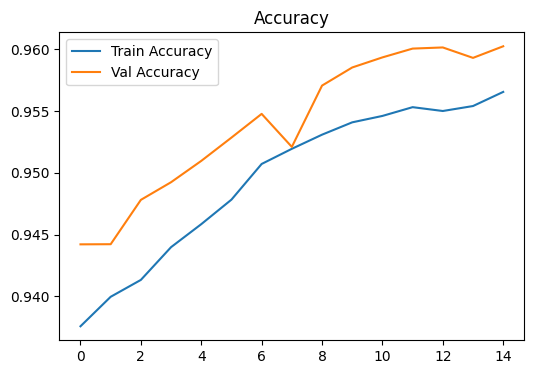

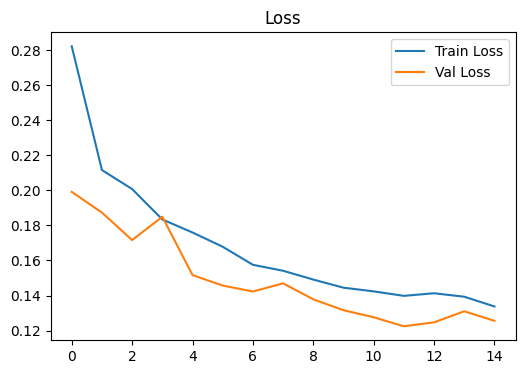

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

# === PRINT FINAL METRICS ===
print("\n===== FINAL METRICS =====")
print("Final Training Accuracy:", history.history["accuracy"][-1])
print("Final Validation Accuracy:", history.history["val_accuracy"][-1])
print("Final Training Loss:", history.history["loss"][-1])
print("Final Validation Loss:", history.history["val_loss"][-1])

# === PRINT ALL EPOCHS IN A TABLE ===
print("\n===== FULL EPOCH HISTORY =====")
df = pd.DataFrame(history.history)
print(df)

# === PLOT ACCURACY ===
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy")
plt.show()

# === PLOT LOSS ===
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.show()
